# Lead-Lag Pairs Trading

## Motivation

Traditional Pairs Trading provides incredibly consistent and provable results, it requires intensive infrastructure to truly reap its benefits. This approach is applied quite a lot in industry, however can be inaccessible to a lot of invidiuals like myslef. We already know that information diffusion is not completely instantaneous and allows for the slight gaps which large companies generally operate in order to profit. Which leads me to the question: What if there is an instant reaction to pricing, but also, what if there's a slightly more lagged reaction which forms due to other factors surrounding the price fluctuations.

This project explores whether time-lagged correlations (which seems to be the technical jargon for these type of thought) between related stocks can be identified and exploited using daily price data, making the strategy a little more accessible and long-term friendly to traders without specialized infrastructure.


## Research Question

There are a few which I am hoping to develop some insight on:

1. Do statistically significant lagged correlations exist between large-cap and mid-cap tech stocks?

2. What is the optimal lag period that maximizes correlation for each stock pair?

3. How does correlation strength vary as we change the lag from 1 to 7+ days?

4. Can we profitably trade based on these identified lead-lag relationships?

## Hypothesis

I believe that larger-cap tech stocks will directly impact smaller related mid cap tech stocks with a predictable time lag. I still believe that the correlation will peak at the smallest time-frames, there will be a "sweet spot" which exists in a certain time frame which allows to make consistent profit.

##Methodology and Trading Strategy

1. Collect 5 years (2020-2024) worth of data for the 6 stocks (3 high-cap leaders, and 3 mid-cap laggers). I picked 5 years because the notebook seems to be able to handle it well and I want to run tests on 2025, and 6 stocks just out of convenience

2. Calculate lagged correlations for time delays ranging from 1 to 7 days
Test all 9 possible leader-lagger pair combinations

3. Identify pairs with statistically significant (p < 0.05) lag relationships

4. Analyze how correlation strength changes as a function of lag time—does it decay smoothly, or are there specific "sweet spot" timeframes?

## Trading Strategy

When the leader moves, take a position in the lagger and hold for the optimal lag period

## Stocks:

leaders = ['AAPL', 'MSFT', 'NVDA']

laggers = ['AMD', 'INTC', 'MU']

In [ ]:
# ALL THE IMPORTS

# Data handling and analysis
import yfinance as yf
import pandas as pd
import numpy as np

# Statistical analysis
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Quality of Life
from datetime import datetime

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Define stock universe
leaders = ['AAPL', 'MSFT', 'NVDA']
laggers = ['AMD', 'INTC', 'MU']

all_tickers = leaders + laggers

print(f"Leaders: {leaders}")
print(f"Laggers: {laggers}")
print(f"Total stocks: {len(all_tickers)}")
print(f"Total pairs to test: {len(leaders) * len(laggers)}")

Leaders: ['AAPL', 'MSFT', 'NVDA']
Laggers: ['AMD', 'INTC', 'MU']
Total stocks: 6
Total pairs to test: 9


In [ ]:
# Download historical data
start_date = '2022-01-01'
end_date = '2024-12-31'
max_lead_const = 7 # How many days ahead are we looking
stock_data = {}

for ticker in all_tickers:
    print(f"Downloading {ticker}...", end=" ")
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    stock_data[ticker] = data['Close']
    print(f"✓ ({len(data)} days)")

print("-" * 50)
print(f"Successfully downloaded {len(stock_data)} stocks")

/tmp/ipython-input-3189085501.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3189085501.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3189085501.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3189085501.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3189085501.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3189085501.py:9: FutureWar

✓ (752 days)
--------------------------------------------------
Successfully downloaded 6 stocks


In [ ]:
# put everything into one dataframe to make it easier to work with

# Using pd.concact because I was just using prices = pd.dataframe but was having
# issues with the datatype and the built in Gemini model suggested the concact function
# which seems to work very well
prices = pd.concat(stock_data.values(), axis=1, keys=stock_data.keys())

print("Date range:", prices.index[0].date(), "to", prices.index[-1].date())
print("Number of trading days:", len(prices))
print("\nFirst few rows:")
print(prices.head())

Date range: 2022-01-03 to 2024-12-30
Number of trading days: 752

First few rows:
                  AAPL        MSFT       NVDA         AMD       INTC  \
Ticker            AAPL        MSFT       NVDA         AMD       INTC   
Date                                                                   
2022-01-03  178.103638  323.898407  30.062769  150.240005  49.350491   
2022-01-04  175.843231  318.344421  29.233372  144.419998  49.285561   
2022-01-05  171.165833  306.123932  27.550627  136.149994  49.962612   
2022-01-06  168.308517  303.704926  28.123518  136.229996  50.092453   
2022-01-07  168.474854  303.859772  27.194321  132.000000  49.563805   

                   MU  
Ticker             MU  
Date                   
2022-01-03  93.653320  
2022-01-04  94.230385  
2022-01-05  92.332878  
2022-01-06  93.555496  
2022-01-07  92.381767  


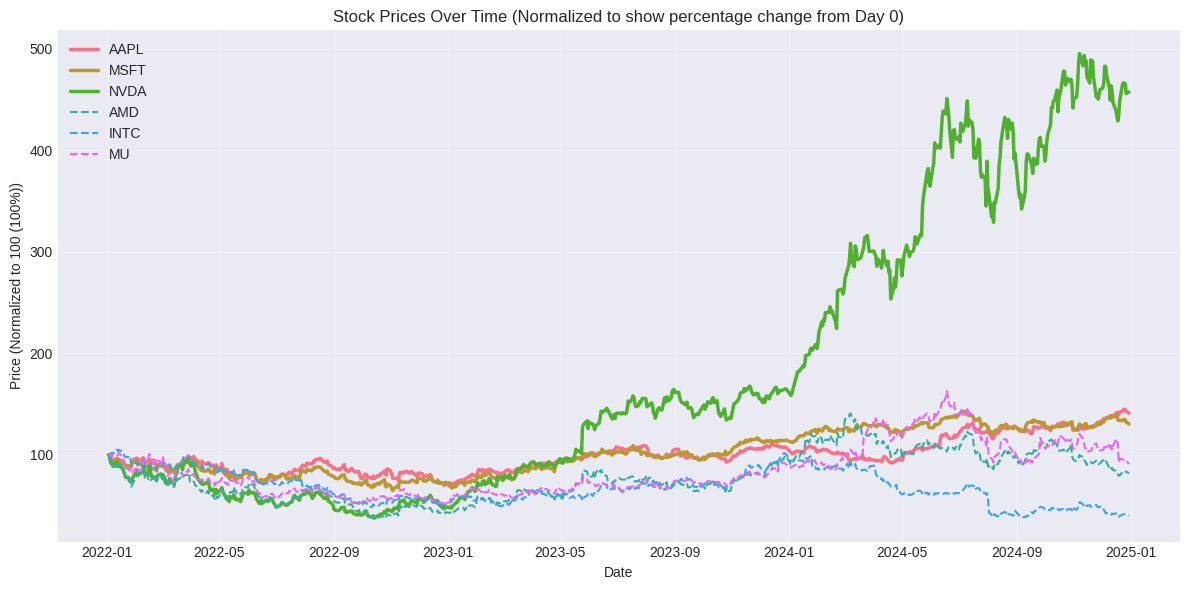

In [ ]:
# making a plot to see if the data looks reasonable
# normalizing everything to start at 100 so they're comparable

fig, ax = plt.subplots(figsize=(12, 6))

for ticker in all_tickers:
    # normalize: just getting a percentage value in reference to the first dat we're considering
    normalized = (prices[ticker] / prices[ticker].iloc[0]) * 100

    # plot leaders with solid lines, laggers with dashed
    if ticker in leaders:
        ax.plot(normalized, label=ticker, linewidth=2.5)
    else:
        ax.plot(normalized, label=ticker, linewidth=1.5, linestyle='--')

ax.set_title('Stock Prices Over Time (Normalized to show percentage change from Day 0)')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Normalized to 100 (100%))')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prep work done
# Now is when I check the correlation

In [ ]:
# function to calculate correlation between leader and lagger with a time delay
def calculate_lagged_correlation(leader_prices, lagger_prices, lag):
    """
    Calculate how correlated the leader's movement today is with
    lagger's movement 'lag' days later

    leader_prices: price series for the leading stock
    lagger_prices: price series for the lagging stock
    lag: number of days delay (e.g., lag=3 means leader today predicts lagger in 3 days)

    Returns: correlation value and p-value for the signficiance of said correlation
    """

    # calculate daily returns (percent change)
    leader_returns = leader_prices.pct_change().dropna()
    lagger_returns = lagger_prices.pct_change().dropna()

    # shift the lagger returns backward by 'lag' days
    # this aligns leader[day 0] with lagger[day 0+lag]
    lagger_lagged = lagger_returns.shift(-lag)

    # drop the NaN values at the end (from shifting)
    # need to make sure both series are the same length
    valid_length = len(leader_returns) - lag
    leader_aligned = leader_returns[:valid_length]
    lagger_aligned = lagger_lagged[:valid_length]

    # calculate correlation using scipy
    correlation, p_value = pearsonr(leader_aligned, lagger_aligned)

    return correlation[0], p_value[0]

In [ ]:
## This is strictly a test cell to make sure the output of the function is as expected

# test it on one example to make sure it works
test_corr, test_p = calculate_lagged_correlation(prices['NVDA'], prices['AMD'], lag=1)
print(f"Test: NVDA -> AMD with 1-day lag")
print(f"Correlation: {test_corr}")
print(f"P-value: {test_p}")
print(f"Significant? {'Yes' if test_p < 0.05 else 'No'}")

Test: NVDA -> AMD with 1-day lag
Correlation: -0.014257885981580436
P-value: 0.6966572119694922
Significant? No


In [ ]:
# function to find the optimal lag for a given pair
def find_optimal_lag(leader_prices, lagger_prices, max_lag=max_lead_const):
    """
    Test different lag periods and find which one has the strongest correlation

    Returns a dictionary with results for each lag
    """
    results = {}

    for lag in range(1, max_lag + 1):
        corr, p_val = calculate_lagged_correlation(leader_prices, lagger_prices, lag)
        results[lag] = {
            'correlation': corr,
            'p_value': p_val,
            'significant': p_val < 0.05
        }

    return results

In [ ]:
## Another testing block

# test on NVDA -> AMD across multiple lags
print("Testing NVDA -> AMD for lags 1-7 days:")
print("-" * 60)
nvda_amd_results = find_optimal_lag(prices['NVDA'], prices['AMD'], max_lag=max_lead_const)

for lag, data in nvda_amd_results.items():
    sig_marker = "***" if data['significant'] else "   "
    print(f"Lag {lag}: Corr = {data['correlation']}, p-value = {data['p_value']} {sig_marker}")

# find the lag with highest absolute correlation
best_lag = max(nvda_amd_results, key=lambda x: abs(nvda_amd_results[x]['correlation']))
print("-" * 60)
print(f"Best lag: {best_lag} days (correlation = {nvda_amd_results[best_lag]['correlation']})")

Testing NVDA -> AMD for lags 1-7 days:
------------------------------------------------------------
Lag 1: Corr = -0.014257885981580436, p-value = 0.6966572119694922    
Lag 2: Corr = -0.00725242683115959, p-value = 0.8429241557431087    
Lag 3: Corr = -0.0457676154347566, p-value = 0.2111946274332371    
Lag 4: Corr = 0.0011744003253801307, p-value = 0.9744368449019587    
Lag 5: Corr = -0.0006637649731572614, p-value = 0.9855598645913739    
Lag 6: Corr = 0.02456735355167781, p-value = 0.5031553203304132    
Lag 7: Corr = 0.07102878581256307, p-value = 0.05279476502716279    
------------------------------------------------------------
Best lag: 7 days (correlation = 0.07102878581256307)


In [ ]:
## Just testing the reverse relationship

# test on NVDA -> AMD across multiple lags
print("Testing AMD -> NVIDIA for lags 1-7 days:")
print("-" * 60)
nvda_amd_results = find_optimal_lag(prices['AMD'], prices['NVDA'], max_lag=max_lead_const)

for lag, data in nvda_amd_results.items():
    sig_marker = "***" if data['significant'] else "   "
    print(f"Lag {lag}: Corr = {data['correlation']}, p-value = {data['p_value']} {sig_marker}")

# find the lag with highest absolute correlation
best_lag = max(nvda_amd_results, key=lambda x: abs(nvda_amd_results[x]['correlation']))
print("-" * 60)
print(f"Best lag: {best_lag} days (correlation = {nvda_amd_results[best_lag]['correlation']})")

Testing AMD -> NVIDIA for lags 1-7 days:
------------------------------------------------------------
Lag 1: Corr = 0.02586205388364296, p-value = 0.4794431550673055    
Lag 2: Corr = -0.034529128568717427, p-value = 0.3453272563861049    
Lag 3: Corr = -0.032596156884112666, p-value = 0.3733385794029478    
Lag 4: Corr = -0.015944977062728377, p-value = 0.6634936061016208    
Lag 5: Corr = 0.03182144362071672, p-value = 0.3854482845328168    
Lag 6: Corr = 0.014298021814547273, p-value = 0.6968141159273982    
Lag 7: Corr = 0.11207468725073748, p-value = 0.0022023094330992036 ***
------------------------------------------------------------
Best lag: 7 days (correlation = 0.11207468725073748)


## What I have so far

I have functions which allow me to automate not just calculating correlation coefficients and their respective p values to understand the signfiicance (I just used built in libraries and tools, need to really understand how they're calculated) and a couple of tests.

From these tests I am seeing an interesting thing: the pair NVDA - AMD seems to not have a very significant correlation going in the direction from leader -> lagger (NVDA -> AMD) but a decently significant relationship going from the lagger to the leader (AMD -> NVDA). This shows us 2 important things: One thing is that the pairs aren't commutative. Another thing is the correlation values are definitely smaller than I am used to seeing in the context of a statistics class

I will write a loop to effectively calculate all possible leader->lagger pairs, and then do the same for

In [ ]:
# test all possible leader -> lagger pairs
all_pair_results = []

for leader in leaders:
    for lagger in laggers:
        # run the lag analysis
        results = find_optimal_lag(prices[leader], prices[lagger], max_lag=max_lead_const)

        # find best lag
        best_lag = max(results, key=lambda x: abs(results[x]['correlation']))
        best_corr = results[best_lag]['correlation']
        best_pval = results[best_lag]['p_value']

        # store results
        all_pair_results.append({
            'leader': leader,
            'lagger': lagger,
            'best_lag': best_lag,
            'correlation': best_corr,
            'p_value': best_pval,
            'significant': best_pval < 0.05
        })

        # print summary
        sig = "***" if best_pval < 0.05 else "   "
        print(f"{leader:6s} -> {lagger:6s}: Best lag = {best_lag} days, "
              f"Corr = {best_corr:7.4f}, p = {best_pval:.4f} {sig}")

print("=" * 80)

# convert to dataframe for easier analysis
results_df = pd.DataFrame(all_pair_results)
print(f"\nSignificant pairs found: {results_df['significant'].sum()} out of {len(results_df)}")

AAPL   -> AMD   : Best lag = 7 days, Corr =  0.0627, p = 0.0873    
AAPL   -> INTC  : Best lag = 7 days, Corr =  0.0774, p = 0.0348 ***
AAPL   -> MU    : Best lag = 2 days, Corr = -0.0542, p = 0.1386    
MSFT   -> AMD   : Best lag = 7 days, Corr =  0.0565, p = 0.1236    
MSFT   -> INTC  : Best lag = 7 days, Corr =  0.0521, p = 0.1553    
MSFT   -> MU    : Best lag = 2 days, Corr = -0.0587, p = 0.1082    
NVDA   -> AMD   : Best lag = 7 days, Corr =  0.0710, p = 0.0528    
NVDA   -> INTC  : Best lag = 7 days, Corr =  0.0872, p = 0.0174 ***
NVDA   -> MU    : Best lag = 7 days, Corr =  0.0486, p = 0.1857    

Significant pairs found: 2 out of 9


In [ ]:
# test all possible leader -> lagger pairs
all_pair_results = []

for lagger in laggers:
    for leader in leaders:
        # run the lag analysis
        results = find_optimal_lag(prices[lagger], prices[leader], max_lag=max_lead_const)

        # find best lag
        best_lag = max(results, key=lambda x: abs(results[x]['correlation']))
        best_corr = results[best_lag]['correlation']
        best_pval = results[best_lag]['p_value']

        # store results
        all_pair_results.append({
            'leader': lagger,
            'lagger': leader,
            'best_lag': best_lag,
            'correlation': best_corr,
            'p_value': best_pval,
            'significant': best_pval < 0.05
        })

        # print summary
        sig = "***" if best_pval < 0.05 else "   "
        print(f"{leader:6s} -> {lagger:6s}: Best lag = {best_lag} days, "
              f"Corr = {best_corr:7.4f}, p = {best_pval:.4f} {sig}")

print("=" * 80)

# convert to dataframe for easier analysis
results_df = pd.DataFrame(all_pair_results)
print(f"\nSignificant pairs found: {results_df['significant'].sum()} out of {len(results_df)}")

AAPL   -> AMD   : Best lag = 7 days, Corr =  0.0834, p = 0.0228 ***
MSFT   -> AMD   : Best lag = 7 days, Corr =  0.0785, p = 0.0323 ***
NVDA   -> AMD   : Best lag = 7 days, Corr =  0.1121, p = 0.0022 ***
AAPL   -> INTC  : Best lag = 4 days, Corr = -0.0695, p = 0.0574    
MSFT   -> INTC  : Best lag = 3 days, Corr = -0.0620, p = 0.0899    
NVDA   -> INTC  : Best lag = 4 days, Corr = -0.0598, p = 0.1024    
AAPL   -> MU    : Best lag = 3 days, Corr = -0.0661, p = 0.0708    
MSFT   -> MU    : Best lag = 3 days, Corr = -0.0938, p = 0.0103 ***
NVDA   -> MU    : Best lag = 3 days, Corr = -0.0615, p = 0.0929    

Significant pairs found: 4 out of 9


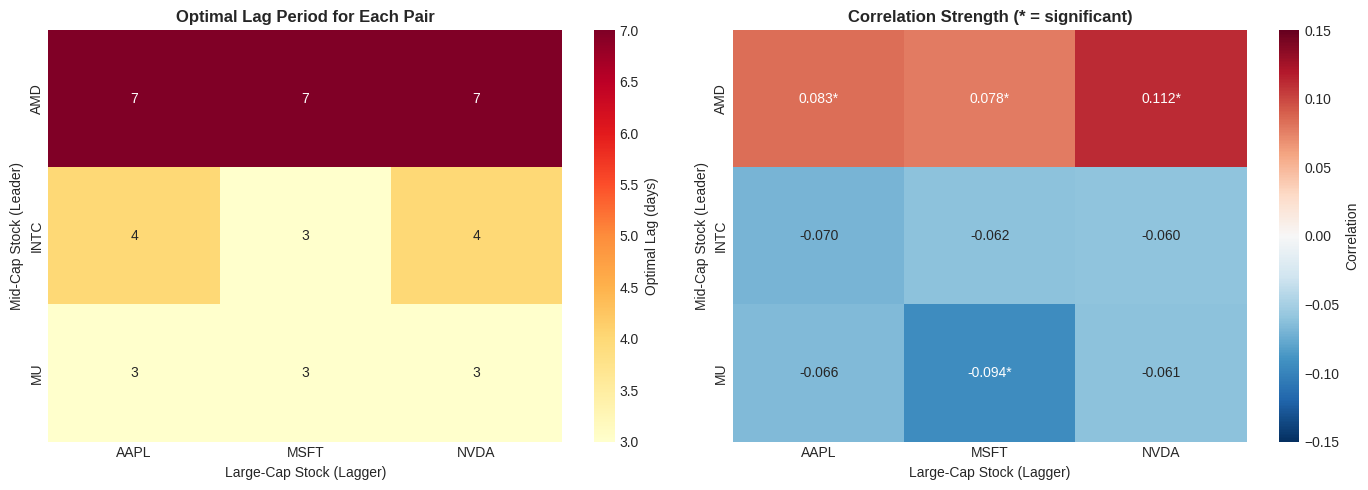

In [ ]:
# create a heatmap showing optimal lag for each pair
# using the lagger -> leader results since those were more significant

# reshape data for heatmap
lag_matrix = results_df.pivot(index='leader', columns='lagger', values='best_lag')
corr_matrix = results_df.pivot(index='leader', columns='lagger', values='correlation')
sig_matrix = results_df.pivot(index='leader', columns='lagger', values='significant')

# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# plot 1: optimal lag heatmap
sns.heatmap(lag_matrix, annot=True, fmt='g', cmap='YlOrRd',
            ax=ax1, cbar_kws={'label': 'Optimal Lag (days)'})
ax1.set_title('Optimal Lag Period for Each Pair', fontweight='bold')
ax1.set_xlabel('Large-Cap Stock (Lagger)')
ax1.set_ylabel('Mid-Cap Stock (Leader)')

# plot 2: correlation heatmap with significance markers
# create custom annotations showing correlation and significance
annot_labels = []
for i in range(len(corr_matrix)):
    row = []
    for j in range(len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        is_sig = sig_matrix.iloc[i, j]
        label = f"{corr_val:.3f}{'*' if is_sig else ''}"
        row.append(label)
    annot_labels.append(row)

sns.heatmap(corr_matrix, annot=annot_labels, fmt='', cmap='RdBu_r', center=0,
            ax=ax2, cbar_kws={'label': 'Correlation'}, vmin=-0.15, vmax=0.15)
ax2.set_title('Correlation Strength (* = significant)', fontweight='bold')
ax2.set_xlabel('Large-Cap Stock (Lagger)')
ax2.set_ylabel('Mid-Cap Stock (Leader)')

plt.tight_layout()
plt.show()

# Conclusions so far and next steps

## Observations

There's smaller correlation values than expected. And out of the 6 stocks studied there seems to be a "sweet" spot already emerging in the form of 2-3 days. Out of all the studied relations, we can see that INTC (Intel) has a correaltion coefficient of 0.114 predicting apple strongest in about 2 days time. I also realize that the direction of the correlation may not be as prominent of a factor as I thought. And even if it is, the directionality is reversed from the initial predictions of laggers and leaders.

## Next Steps

I want to make a quick shift and before setting up some backtesting introducing a few more stocks into the analysis. I will make similar figures to the figures above but for about the top 20 stocks. Instead of breaking them down into leaders and laggers. I will simply run the analysis with every stock on every other stock in both directions. Which will truly test the limits of the hypothesis, and also really make strong use of the heatmap.

After this is done, for backtesting, I will take the most significant pairs of stocks and basically utlize the pre-determined data to test how much money is made based on hard-coded day values over the course of 2025. Compare the strategy with the S&P and value of simply holding all the initial purchases over the course of the year.

In [ ]:
# expanding to top 20 tech stocks by market cap
# mix of mega-cap, large-cap, and mid-cap
top_20_tech = [
    # Mega-cap (>$1T)
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA',
    # Large-cap ($200B-$1T)
    'AVGO', 'ORCL', 'ASML', 'AMD', 'ADBE', 'CRM', 'NFLX',
    # Large-cap continued
    'QCOM', 'INTC', 'CSCO', 'TXN', 'AMAT', 'MU'
]

print(f"Total stocks: {len(top_20_tech)}")
print(f"Total pairs to test (both directions): {len(top_20_tech) * (len(top_20_tech) - 1)}")
print("\nStocks:", top_20_tech)

# download data for all 20 stocks
stock_data_20 = {}

print("\nDownloading 20 stocks...")
print("-" * 60)

for ticker in top_20_tech:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    stock_data_20[ticker] = data['Close'].squeeze()

print("-" * 60)
print(f"Successfully downloaded {len(stock_data_20)} stocks")

# create combined dataframe
prices_20 = pd.concat(stock_data_20.values(), axis=1, keys=stock_data_20.keys())
print(f"\nDate range: {prices_20.index[0].date()} to {prices_20.index[-1].date()}")
print(f"Shape: {prices_20.shape}")

Total stocks: 20
Total pairs to test (both directions): 380

Stocks: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'ORCL', 'ASML', 'AMD', 'ADBE', 'CRM', 'NFLX', 'QCOM', 'INTC', 'CSCO', 'TXN', 'AMAT', 'MU']

------------------------------------------------------------


/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: Fut

------------------------------------------------------------
Successfully downloaded 20 stocks

Date range: 2022-01-03 to 2024-12-30
Shape: (752, 20)


/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2044649285.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


### Now doing the Testing


In [ ]:
## JUST REDIFINING A FUNCTION BECAUSE earlier code needs a value whearas this piece of analysis needs an array

# redefining the function to fix the indexing issue
def calculate_lagged_correlation(leader_prices, lagger_prices, lag):
    """
    Calculate how correlated the leader's movement today is with
    lagger's movement 'lag' days later
    """
    # calculate daily returns
    leader_returns = leader_prices.pct_change().dropna()
    lagger_returns = lagger_prices.pct_change().dropna()

    # shift the lagger returns backward by 'lag' days
    lagger_lagged = lagger_returns.shift(-lag)

    # align both series
    valid_length = len(leader_returns) - lag
    leader_aligned = leader_returns[:valid_length]
    lagger_aligned = lagger_lagged[:valid_length]

    # calculate correlation
    correlation, p_value = pearsonr(leader_aligned, lagger_aligned)

    return correlation, p_value  # fixed - no [0] indexing

In [ ]:
# test every stock against every other stock in both directions

print("=" * 80)

all_results = []

for stock_a in top_20_tech:
    for stock_b in top_20_tech:
        if stock_a == stock_b:
            continue  # skip testing a stock against itself

        # run lag analysis
        results = find_optimal_lag(prices_20[stock_a], prices_20[stock_b], max_lag=max_lead_const)

        # find best lag
        best_lag = max(results, key=lambda x: abs(results[x]['correlation']))
        best_corr = results[best_lag]['correlation']
        best_pval = results[best_lag]['p_value']

        # handle if correlation/p_value are arrays (from earlier code)
        if hasattr(best_corr, '__len__'):
            best_corr = best_corr[0]
        if hasattr(best_pval, '__len__'):
            best_pval = best_pval[0]

        # store
        all_results.append({
            'stock_a': stock_a,
            'stock_b': stock_b,
            'best_lag': best_lag,
            'correlation': best_corr,
            'p_value': best_pval,
            'significant': best_pval < 0.05
        })

# convert to dataframe
full_results_df = pd.DataFrame(all_results)

print("=" * 80)
print(f"Total pairs tested: {len(full_results_df)}")
print(f"Significant pairs (p < 0.05): {full_results_df['significant'].sum()}")
print(f"Percentage significant: {full_results_df['significant'].mean() * 100:.1f}%")
print(f"\nTop 10 most significant pairs:")
print(full_results_df.nsmallest(10, 'p_value')[['stock_a', 'stock_b', 'best_lag', 'correlation', 'p_value']])

Total pairs tested: 380
Significant pairs (p < 0.05): 89
Percentage significant: 23.4%

Top 10 most significant pairs:
    stock_a stock_b  best_lag  correlation   p_value
253    NFLX    TSLA         4     0.156689  0.000017
252    NFLX    META         6    -0.145963  0.000064
292    INTC    AVGO         4    -0.130869  0.000335
260    NFLX    QCOM         6    -0.127581  0.000482
282    QCOM     TXN         1    -0.116256  0.001426
99     META    AMZN         1    -0.116089  0.001449
301    INTC     TXN         4    -0.115147  0.001620
192     AMD    NVDA         7     0.112075  0.002202
320    CSCO     TXN         1    -0.106176  0.003601
299    INTC    QCOM         4    -0.106011  0.003723


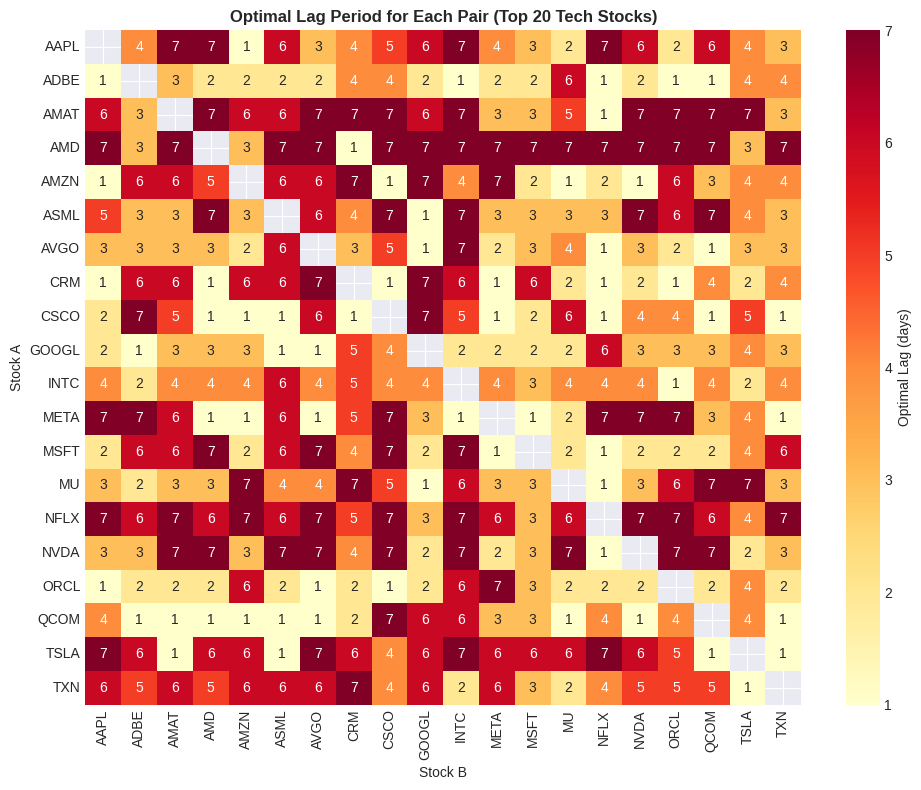

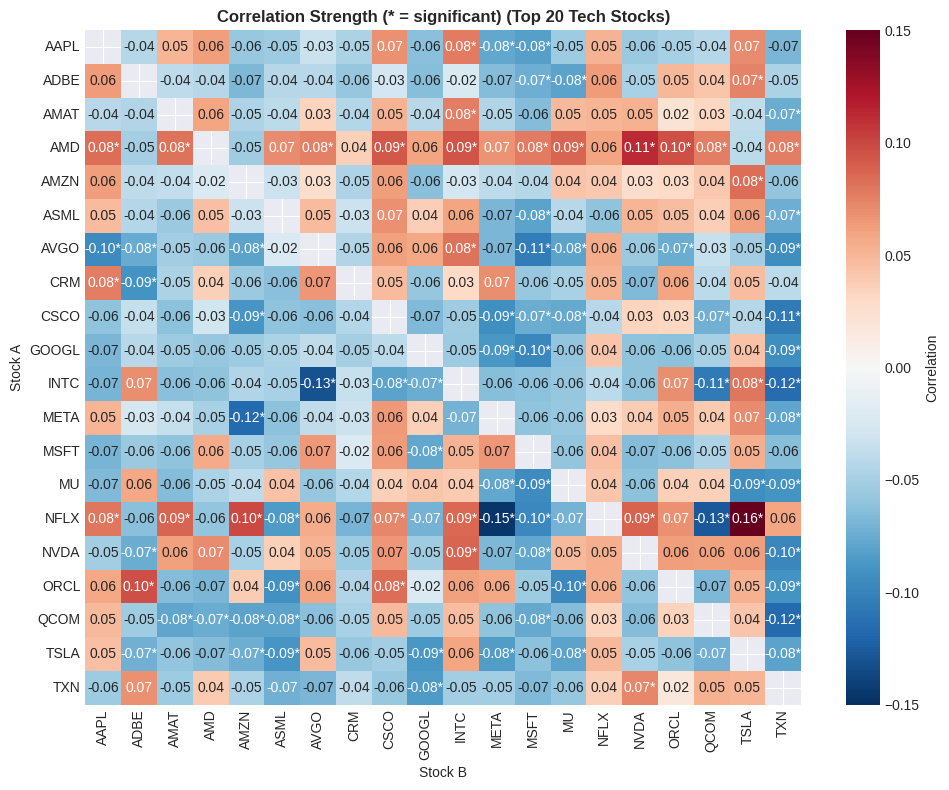

In [ ]:
# create heatmaps showing optimal lag and correlation for each pair for the top 20 tech stocks

# reshape data for heatmap using full_results_df
lag_matrix = full_results_df.pivot(index='stock_a', columns='stock_b', values='best_lag')
corr_matrix = full_results_df.pivot(index='stock_a', columns='stock_b', values='correlation')
sig_matrix = full_results_df.pivot(index='stock_a', columns='stock_b', values='significant')

# --- Plot 1: Optimal Lag Heatmap ---
fig1, ax1 = plt.subplots(figsize=(10, 8)) # Adjusted figure size for a single plot
sns.heatmap(lag_matrix, annot=True, fmt='g', cmap='YlOrRd',
            ax=ax1, cbar_kws={'label': 'Optimal Lag (days)'})
ax1.set_title('Optimal Lag Period for Each Pair (Top 20 Tech Stocks)', fontweight='bold')
ax1.set_xlabel('Stock B')
ax1.set_ylabel('Stock A')
plt.tight_layout()
plt.show()

# --- Plot 2: Correlation Heatmap with Significance Markers ---
fig2, ax2 = plt.subplots(figsize=(10, 8)) # Adjusted figure size for a single plot

# create custom annotations showing correlation and significance
annot_labels = []
for i in range(len(corr_matrix)):
    row = []
    for j in range(len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        is_sig = sig_matrix.iloc[i, j]
        label = f"{corr_val:.2f}{'*' if is_sig else ''}"
        row.append(label)
    annot_labels.append(row)

sns.heatmap(corr_matrix, annot=annot_labels, fmt='', cmap='RdBu_r', center=0,
            ax=ax2, cbar_kws={'label': 'Correlation'}, vmin=-0.15, vmax=0.15)
ax2.set_title('Correlation Strength (* = significant) (Top 20 Tech Stocks)', fontweight='bold')
ax2.set_xlabel('Stock B')
ax2.set_ylabel('Stock A')
plt.tight_layout()
plt.show()

# Now we can backtest these numbers

I will be taking these computed statistics with respect to the correlation coefficients and p-values to monitor the market in 2025 and make trades. Here's the outline of the trading strategy:

1. Monitor all significant pairs (Stock A → Stock B with optimal lag n)
Check Stock A's return:

2. If Stock A moves ≥0.75% (up or down), trigger a trade
Skip if already have an open position on this pair


3. Determine position direction:

* If correlation > 0: match Stock A's direction (A up → buy B, A down → short B)
* If correlation < 0: opposite direction (A up → short B, A down → buy B)


4. Execute trade:

* Enter position in Stock B at today's closing price
* Hold for exactly the optimal lag days
* Exit automatically after lag period


5. Close expired positions that have reached their exit date

In [ ]:
# Download 2025 data specifically for backtesting
backtest_start = '2025-01-01'
backtest_end = '2025-12-31'

print("Downloading 2025 data for backtesting...")
print("-" * 60)

stock_data_2025 = {}

for ticker in top_20_tech:
    data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)
    stock_data_2025[ticker] = data['Close'].squeeze()

print("-" * 60)
print(f"Successfully downloaded {len(stock_data_2025)} stocks")

# Create 2025 dataframe
prices_2025 = pd.concat(stock_data_2025.values(), axis=1, keys=stock_data_2025.keys())
print(f"\nBacktest period: {prices_2025.index[0].date()} to {prices_2025.index[-1].date()}")
print(f"Trading days in 2025: {len(prices_2025)}")

# Filter to significant pairs only
tradeable_pairs = full_results_df[full_results_df['significant'] == True].copy()
print(f"\nTrading {len(tradeable_pairs)} significant pairs")

# Setup
initial_capital = 100000
position_size = initial_capital / len(tradeable_pairs)
entry_threshold = 0.0075  # 1.5%

print(f"Initial capital: ${initial_capital:,.0f}")
print(f"Position size per pair: ${position_size:,.2f}")
print(f"Entry threshold: {entry_threshold*100}%")

# Track trades
trades = []
open_positions = {}  # track which pairs have open positions

# Calculate daily returns for all stocks
returns_2025 = prices_2025.pct_change()

# Iterate through each day
for i in range(len(prices_2025) - max(tradeable_pairs['best_lag'])):  # leave room for exits
    current_date = prices_2025.index[i]

    # Check each pair for entry signals
    for _, pair in tradeable_pairs.iterrows():
        stock_a = pair['stock_a']
        stock_b = pair['stock_b']
        lag = pair['best_lag']
        correlation = pair['correlation']
        pair_id = f"{stock_a}_{stock_b}"

        # Skip if already have open position on this pair
        if pair_id in open_positions:
            continue

        # Check if Stock A moved enough to trigger entry
        a_return = returns_2025.loc[current_date, stock_a]

        if abs(a_return) >= entry_threshold:
            # Determine position direction based on correlation
            if correlation > 0:
                # Positive correlation: same direction
                position_direction = 'long' if a_return > 0 else 'short'
            else:
                # Negative correlation: opposite direction
                position_direction = 'short' if a_return > 0 else 'long'

            # Enter position
            entry_price = prices_2025.loc[current_date, stock_b]
            exit_date_idx = i + lag

            if exit_date_idx < len(prices_2025):
                exit_date = prices_2025.index[exit_date_idx]
                exit_price = prices_2025.loc[exit_date, stock_b]

                # Calculate P&L
                if position_direction == 'long':
                    pnl = (exit_price - entry_price) / entry_price * position_size
                else:  # short
                    pnl = (entry_price - exit_price) / entry_price * position_size

                # Record trade
                trades.append({
                    'entry_date': current_date,
                    'exit_date': exit_date,
                    'stock_a': stock_a,
                    'stock_b': stock_b,
                    'a_return': a_return,
                    'direction': position_direction,
                    'lag': lag,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'return_pct': pnl / position_size
                })

                # Mark position as open
                open_positions[pair_id] = exit_date

    # Close positions that have reached exit date
    expired = [pair_id for pair_id, exit_date in open_positions.items()
               if exit_date <= current_date]
    for pair_id in expired:
        del open_positions[pair_id]

# Convert to DataFrame
trades_df = pd.DataFrame(trades)

print(f"\n{'='*80}")
print(f"BACKTEST RESULTS: ")
print(f"Total trades executed: {len(trades_df)}")
print(f"Winning trades: {(trades_df['pnl'] > 0).sum()}")
print(f"Losing trades: {(trades_df['pnl'] < 0).sum()}")
print(f"Win rate: {(trades_df['pnl'] > 0).mean() * 100:.2f}%")
print(f"\nTotal P&L: ${trades_df['pnl'].sum():,.2f}")
print(f"Average P&L per trade: ${trades_df['pnl'].mean():,.2f}")
print(f"Best trade: ${trades_df['pnl'].max():,.2f}")
print(f"Worst trade: ${trades_df['pnl'].min():,.2f}")
print(f"\nTotal return: {(trades_df['pnl'].sum() / initial_capital) * 100:.2f}%")
print(f"Average return per trade: {trades_df['return_pct'].mean() * 100:.2f}%")

------------------------------------------------------------


/tmp/ipython-input-1080215877.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)
/tmp/ipython-input-1080215877.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)
/tmp/ipython-input-1080215877.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)
/tmp/ipython-input-1080215877.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)
/tmp/ipython-input-1080215877.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=backtest_start, end=backtest_end, progress=False)


------------------------------------------------------------
Successfully downloaded 20 stocks

Backtest period: 2025-01-02 to 2025-12-30
Trading days in 2025: 249

Trading 89 significant pairs
Initial capital: $100,000
Position size per pair: $1,123.60
Entry threshold: 0.75%

BACKTEST RESULTS: 
Total trades executed: 4679
Winning trades: 2303
Losing trades: 2363
Win rate: 49.22%

Total P&L: $4,791.47
Average P&L per trade: $1.02
Best trade: $478.32
Worst trade: $-387.72

Total return: 4.79%
Average return per trade: 0.09%


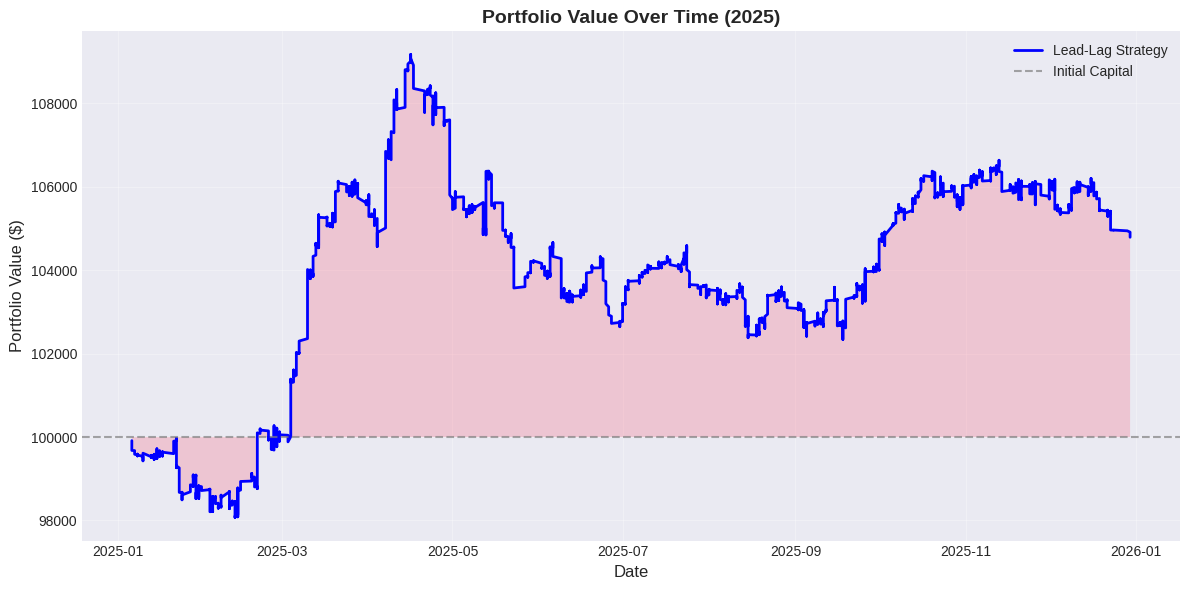

Starting value: $100,000
Ending value: $104,791.47
Total gain: $4,791.47


In [ ]:
# Create equity curve showing portfolio value over time
cumulative_pnl = trades_df.sort_values('exit_date')['pnl'].cumsum()
portfolio_value = initial_capital + cumulative_pnl

plt.figure(figsize=(12, 6))
plt.plot(trades_df.sort_values('exit_date')['exit_date'], portfolio_value,
         linewidth=2, label='Lead-Lag Strategy', color='blue')
plt.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.7, label='Initial Capital')
plt.fill_between(trades_df.sort_values('exit_date')['exit_date'],
                 initial_capital, portfolio_value, alpha=0.3)

plt.title('Portfolio Value Over Time (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Starting value: ${initial_capital:,.0f}")
print(f"Ending value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"Total gain: ${portfolio_value.iloc[-1] - initial_capital:,.2f}")